In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [5]:
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

In [6]:
filtered_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [7]:
filtered_data.shape

(525814, 10)

# 1. Data Cleaning

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
# 1 is positive, 0 is negative
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = final['Score']
positiveNegative = actualScore.map(partition) 

In [13]:
final['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [16]:
nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sanjay\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [17]:
stop1={'not','very','no','nor','or','off'}

In [18]:
stop=stop-stop1

In [19]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")    

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:56<00:00, 1021.85it/s]


In [23]:
#Saving for later assignment
final.to_csv("Clean_data.csv",index=False)

# 2. Data seperation for train cv and test

In [20]:
clean_data=final
# Checking the positive and negative labels
clean_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [21]:
#Randomly selecting 50k records
filter_data_positive=clean_data[clean_data.Score==1].sample(50000,random_state=17)
filter_data_positive.sort_values(by='Time',inplace=True,ascending=True)

#selecting all -ve records records
filter_data_negative=clean_data[clean_data.Score==0].sample(50000,random_state=17)
filter_data_negative.sort_values(by='Time',inplace=True,ascending=True)

In [22]:
# Splitting Train,CV and Test for positive data
row=filter_data_positive.shape[0]
split=int(row*0.6)
train_data_positive=filter_data_positive[:split]
cv_data_positive=filter_data_positive[split:int(row*0.8)]
test_data_positive=filter_data_positive[int(row*0.8):row]
print("Total_positive_data",filter_data_positive.shape)
print("train",train_data_positive.shape,"CV",cv_data_positive.shape,"test",test_data_positive.shape)

Total_positive_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)


In [24]:
# Splitting Train,CV and Test for -ve data
row=filter_data_negative.shape[0]
split=int(row*0.6)
train_data_negative=filter_data_negative[:split]
cv_data_negative=filter_data_negative[split:int(row*0.8)]
test_data_negative=filter_data_negative[int(row*0.8):row]
print("Total_negative_data",filter_data_negative.shape)
print("train",train_data_negative.shape,"CV",cv_data_negative.shape,"test",test_data_negative.shape)

Total_negative_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)


In [25]:
# Combining +ve and -ve train data and sorting based on time
train_data=np.vstack((train_data_positive, train_data_negative))
train_data=pd.DataFrame(train_data)
train_data.columns=clean_data.columns
train_data.sort_values(by='Time',inplace=True,ascending=True)
print(train_data.shape)
# Checking the positive and negative labels
train_data['Score'].value_counts()

(60000, 11)


1    30000
0    30000
Name: Score, dtype: int64

In [26]:
# Combining +ve and -ve CV data and sorting based on time
cv_data=np.vstack((cv_data_positive,cv_data_negative))
cv_data=pd.DataFrame(cv_data)
cv_data.columns=clean_data.columns
cv_data.sort_values(by='Time',inplace=True,ascending=True)
print(cv_data.shape)
# Checking the positive and negative labels
cv_data['Score'].value_counts()

(20000, 11)


1    10000
0    10000
Name: Score, dtype: int64

In [27]:
# Combining +ve and -ve test data and sorting based on time
test_data=np.vstack((test_data_positive, test_data_negative))
test_data=pd.DataFrame(test_data)
test_data.columns=clean_data.columns
test_data.sort_values(by='Time',inplace=True,ascending=True)
print(test_data.shape)
# Checking the positive and negative labels
test_data['Score'].value_counts()

(20000, 11)


1    10000
0    10000
Name: Score, dtype: int64

# 3. Applying KNN brute force using BOW, SET 1

In [28]:
# Please write all the code with proper documentation

import gc; gc.collect()
# Converting text to vector using Bag of words to all train, CV and test
count_vect = CountVectorizer(min_df=15) #in scikit-learn
training_counts = count_vect.fit_transform(train_data['CleanedText'])
cv_counts = count_vect.transform(cv_data['CleanedText'])
test_counts = count_vect.transform(test_data['CleanedText'])
gc.collect()


0

In [29]:
# converting sparse vector to dense vector
training_count=training_counts.toarray()
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)

 training_counts  (60000, 5663) cv_counts  (20000, 5663) test_counts (20000, 5663)


In [30]:
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()

0

In [31]:
train_traget=train_data['Score'].astype('int')
cv_target=cv_data['Score'].astype('int')
test_target=test_data['Score'].astype('int')

In [32]:
from sklearn.decomposition import TruncatedSVD
svd_obj = TruncatedSVD(n_components=50, algorithm='arpack')
svd_obj.fit(training_counts.asfptype())

TruncatedSVD(algorithm='arpack', n_components=50, n_iter=5, random_state=None,
       tol=0.0)

In [33]:
train_svd = pd.DataFrame(svd_obj.transform(training_counts.asfptype()))
cv_svd = pd.DataFrame(svd_obj.transform(cv_counts.asfptype()))
test_svd = pd.DataFrame(svd_obj.transform(test_counts.asfptype()))
#print(" training_counts ",train_svd.shape,"cv_counts ",cv_svd.shape,"test_counts",test_svd.shape)

In [34]:
n_comp=50
train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
cv_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]

In [35]:
train_svd.head(2)

,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10,...,svd_desc_41,svd_desc_42,svd_desc_43,svd_desc_44,svd_desc_45,svd_desc_46,svd_desc_47,svd_desc_48,svd_desc_49,svd_desc_50
0,0.303823,-0.066963,0.047881,0.028230,-0.048800,-0.105731,0.399573,0.045085,-0.024884,-0.009258,...,-0.089986,0.034925,-0.024495,-0.061932,-0.007293,0.026484,0.039704,-0.001880,-0.038657,0.094069
1,0.602175,-0.015419,-0.003409,0.014688,-0.141949,-0.247761,0.095429,0.135765,-0.119683,0.002937,...,-0.099661,-0.061025,0.108056,0.050797,0.010312,-0.009536,0.049105,-0.029811,-0.087806,0.093894


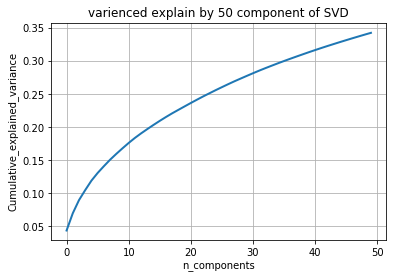

In [36]:
# SVD Varience explained
cum_var_explained = np.cumsum(svd_obj.explained_variance_ratio_)

# Plot the SVD spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.title("varienced explain by 50 component of SVD")
plt.ylabel('Cumulative_explained_variance')
plt.show()

**Observation**

We can see that with 50 compenents of SVD we are getting around 35% of variance of BOW data

**Training KNN Brute using BOW SVD**

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
n_neighbors=[1,3,5,7,9,11,13,15,17,21,33,35,41,51]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(n_neighbors):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)

    # fitting the model on crossvalidation train
    knn.fit(train_svd, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = knn.predict(cv_svd)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, knn.predict(train_svd))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  7%|▋         | 1/14 [00:02<00:31,  2.46s/it]

 Alpha value:  1  AUC:  0.6070499999999999  Acc:  60.705  auc_train  0.9999833333333333


 14%|█▍        | 2/14 [00:08<00:42,  3.53s/it]

 Alpha value:  3  AUC:  0.6375  Acc:  63.74999999999999  auc_train  0.8155499999999999


 21%|██▏       | 3/14 [00:15<00:51,  4.67s/it]

 Alpha value:  5  AUC:  0.6528999999999999  Acc:  65.29  auc_train  0.7733333333333332
 Alpha value:  7  AUC:  0.6593499999999999  Acc:  65.935  auc_train  0.7538333333333334


 36%|███▌      | 5/14 [00:33<01:00,  6.72s/it]

 Alpha value:  9  AUC:  0.6648000000000001  Acc:  66.47999999999999  auc_train  0.7414166666666666


 43%|████▎     | 6/14 [00:42<01:00,  7.60s/it]

 Alpha value:  11  AUC:  0.66445  Acc:  66.445  auc_train  0.7349166666666666


 50%|█████     | 7/14 [00:52<00:58,  8.36s/it]

 Alpha value:  13  AUC:  0.6695000000000001  Acc:  66.95  auc_train  0.72815
 Alpha value:  15  AUC:  0.67165  Acc:  67.16499999999999  auc_train  0.7253999999999998


 64%|██████▍   | 9/14 [01:14<00:48,  9.71s/it]

 Alpha value:  17  AUC:  0.6731499999999999  Acc:  67.315  auc_train  0.7202666666666666
 Alpha value:  21  AUC:  0.67155  Acc:  67.155  auc_train  0.7146666666666667


 79%|███████▊  | 11/14 [01:41<00:34, 11.56s/it]

 Alpha value:  33  AUC:  0.6753  Acc:  67.53  auc_train  0.7048499999999999


 86%|████████▌ | 12/14 [01:55<00:24, 12.46s/it]

 Alpha value:  35  AUC:  0.67485  Acc:  67.485  auc_train  0.7035333333333333


 93%|█████████▎| 13/14 [02:10<00:13, 13.33s/it]

 Alpha value:  41  AUC:  0.6759  Acc:  67.58999999999999  auc_train  0.7006333333333334


100%|██████████| 14/14 [02:27<00:00, 14.35s/it]

 Alpha value:  51  AUC:  0.67465  Acc:  67.465  auc_train  0.6965333333333332


In [36]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values(),label='CV_AUC')
    plt.plot(list(train_map.keys()), train_map.values(),label='Train_AUC')
#     plt.semilogx(alpha, train_map.values(), label='Train_AUC')
#     plt.semilogx(alpha, test_map.values(), label='CV_AUC')
    plt.xlabel('k value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.xticks(n_neighbors)
    plt.grid()
    return plt

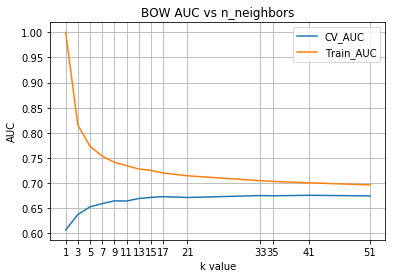

In [37]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs n_neighbors',n_neighbors)
plt.show()

**Observation**

We can see that when k was small i.e 1 model was overfitting; training AUC was 100% but test AUC was lower around 61%. As we increased the k value model started converging to optimal value of k=41 with train auc 70% and cv auc 68%. We can see that the train and test difference is very less so model is well fitting on current feature. If we want to increased accuracy further we need to add other important features.

In [38]:
#Fitting usig best k
best_k=41
knn = KNeighborsClassifier(n_neighbors=best_k,n_jobs=-1)
knn.fit(train_svd, train_traget)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=41, p=2,
           weights='uniform')

In [39]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = knn.predict_proba(train_svd)
y_true_test = test_target
y_probas_test = knn.predict_proba(test_svd)

In [40]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

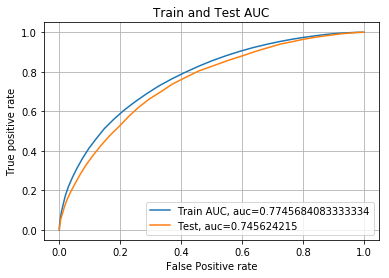

In [41]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

**Observation**

We can see that the train and test auc is almost same, so model is well fitting on current feature. If we want to increase the accuracy further we need to add some new features.

In [42]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, knn.predict(test_svd))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

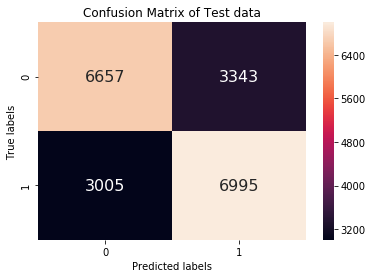

In [43]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

**Observation**

Here we have more no of elements at diagonal than off diagonal i.e more value of TP and TN compare to FP and FN, so model is working file with the current features. If we want to increase TP and TN further we need to do feature engineering.

# 4. KNN with KDTree using BOW  set 2

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
n_neighbors=[1,3,5,7,9,11,13,15,17,21,33,35,41]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(n_neighbors):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=-1)

    # fitting the model on crossvalidation train
    knn.fit(train_svd, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = knn.predict(cv_svd)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, knn.predict(train_svd))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  8%|▊         | 1/13 [00:01<00:18,  1.51s/it]

 Alpha value:  1  AUC:  0.6070499999999999  Acc:  60.705  auc_train  0.9999833333333333


 15%|█▌        | 2/13 [00:07<00:30,  2.75s/it]

 Alpha value:  3  AUC:  0.6375  Acc:  63.74999999999999  auc_train  0.8155499999999999
 Alpha value:  5  AUC:  0.6528999999999999  Acc:  65.29  auc_train  0.7733333333333332


 31%|███       | 4/13 [00:21<00:46,  5.17s/it]

 Alpha value:  7  AUC:  0.6593499999999999  Acc:  65.935  auc_train  0.7538333333333334
 Alpha value:  9  AUC:  0.6648000000000001  Acc:  66.47999999999999  auc_train  0.7414166666666666


 46%|████▌     | 6/13 [00:40<00:50,  7.20s/it]

 Alpha value:  11  AUC:  0.66445  Acc:  66.445  auc_train  0.7349166666666666


 54%|█████▍    | 7/13 [00:50<00:48,  8.06s/it]

 Alpha value:  13  AUC:  0.6695000000000001  Acc:  66.95  auc_train  0.72815
 Alpha value:  15  AUC:  0.67165  Acc:  67.16499999999999  auc_train  0.7253999999999998


 69%|██████▉   | 9/13 [01:11<00:37,  9.43s/it]

 Alpha value:  17  AUC:  0.6731499999999999  Acc:  67.315  auc_train  0.7202666666666666
 Alpha value:  21  AUC:  0.67155  Acc:  67.155  auc_train  0.7146666666666667


 77%|███████▋  | 10/13 [01:23<00:30, 10.20s/it]

 Alpha value:  33  AUC:  0.6753  Acc:  67.53  auc_train  0.7048499999999999


 85%|████████▍ | 11/13 [01:37<00:22, 11.29s/it]

 Alpha value:  35  AUC:  0.67485  Acc:  67.485  auc_train  0.7035333333333333


100%|██████████| 13/13 [02:06<00:00, 13.03s/it]

 Alpha value:  41  AUC:  0.6759  Acc:  67.58999999999999  auc_train  0.7006333333333334


In [45]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values(),label='CV_AUC')
    plt.plot(list(train_map.keys()), train_map.values(),label='Train_AUC')
#     plt.semilogx(alpha, train_map.values(), label='Train_AUC')
#     plt.semilogx(alpha, test_map.values(), label='CV_AUC')
    plt.xlabel('k value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.xticks(n_neighbors)
    plt.grid()
    return plt

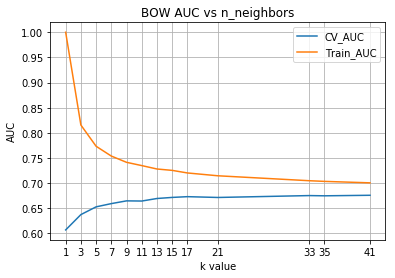

In [46]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs n_neighbors',n_neighbors)
plt.show()

**Observation**

We can see that when k was small i.e 1 model was overfitting; training AUC was 100% but CV AUC was lower around 61%. As we increased the k value model started converging to optimal value of k=41 with train auc 70% and cv auc 68%. We can see that the train and test difference is very less so model is well fitting on current feature. If we want to increased accuracy further we need to add other important features or can do the feature engineering.

In [47]:
#Fitting usig best k
best_k=41
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree',n_jobs=-1)
knn.fit(train_svd, train_traget)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=41, p=2,
           weights='uniform')

In [48]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = knn.predict_proba(train_svd)
y_true_test = test_target
y_probas_test = knn.predict_proba(test_svd)

In [49]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

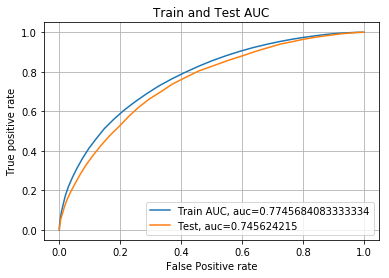

In [50]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

**Observation**

We can see that the train and test auc is almost same, so model is well fitting on current feature. If we want to increase the accuracy further we need to add some new features.

In [51]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, knn.predict(test_svd))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

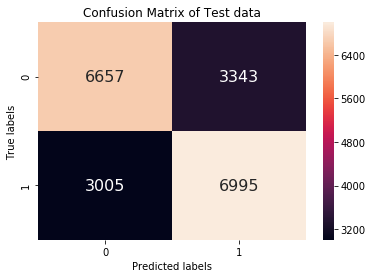

In [52]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

**Observation**

Here we have more no of elements at diagonal than off diagonal i.e more value of TP and TN compare to FP and FN, so model is working file with the current features. If we want to increase TP and TN further we need to do feature engineering.

# 5. Applying KNN brute force on TFIDF, SET 3

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(2,3),min_df=10,max_features=10000)
training_counts = tf_idf_vect.fit_transform(train_data['CleanedText'])
cv_counts = tf_idf_vect.transform(cv_data['CleanedText'])
test_counts = tf_idf_vect.transform(test_data['CleanedText'])
gc.collect()

2279

In [38]:
from sklearn.decomposition import TruncatedSVD
svd_obj = TruncatedSVD(n_components=50, algorithm='arpack')
svd_obj.fit(training_counts.asfptype())
train_svd = pd.DataFrame(svd_obj.transform(training_counts.asfptype()))
cv_svd = pd.DataFrame(svd_obj.transform(cv_counts.asfptype()))
test_svd = pd.DataFrame(svd_obj.transform(test_counts.asfptype()))
print(" training_counts ",train_svd.shape,"cv_counts ",cv_svd.shape,"test_counts",test_svd.shape)

 training_counts  (60000, 50) cv_counts  (20000, 50) test_counts (20000, 50)


In [39]:
n_comp=50
train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
cv_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]

In [40]:
train_svd.tail(3)

,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10,...,svd_desc_41,svd_desc_42,svd_desc_43,svd_desc_44,svd_desc_45,svd_desc_46,svd_desc_47,svd_desc_48,svd_desc_49,svd_desc_50
59997,0.058119,-0.056063,0.107570,0.001206,-0.000504,-0.023774,0.014335,0.006410,0.006833,-0.004048,...,0.036914,0.007319,-0.011433,0.032510,-0.007954,0.006396,-0.001821,0.008306,-0.003511,-0.007520
59998,0.059906,-0.091346,-0.103095,-0.106678,0.206479,-0.045480,-0.034667,-0.053261,0.069873,-0.000124,...,-0.012400,-0.006097,-0.000638,0.018046,0.015083,0.001680,0.006871,0.002572,-0.009614,-0.006511
59999,0.068214,-0.082765,-0.090727,-0.073319,0.182432,-0.037924,-0.032693,-0.048393,0.065685,-0.000219,...,-0.015353,-0.008562,-0.008760,0.007177,-0.001883,-0.012842,0.004128,0.007509,-0.008043,0.000007


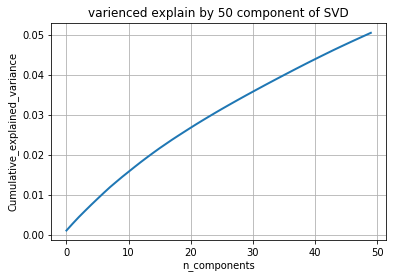

In [41]:
# SVD Varience explained
cum_var_explained = np.cumsum(svd_obj.explained_variance_ratio_)

# Plot the SVD spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.title("varienced explain by 50 component of SVD")
plt.ylabel('Cumulative_explained_variance')
plt.show()

**Observation**

We can see that with 50 compenents of SVD we are getting 50% of variance of TFIDF data

**Training KNN Brute using TFIDF**

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
n_neighbors=[1,3,5,7,9,11,13,15,17,21,33,35,41,51]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(n_neighbors):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)

    # fitting the model on crossvalidation train
    knn.fit(train_svd, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = knn.predict(cv_svd)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, knn.predict(train_svd))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  7%|▋         | 1/14 [00:02<00:36,  2.82s/it]

 Alpha value:  1  AUC:  0.7123499999999999  Acc:  71.235  auc_train  0.99395


 14%|█▍        | 2/14 [00:08<00:44,  3.69s/it]

 Alpha value:  3  AUC:  0.7461499999999999  Acc:  74.615  auc_train  0.8565833333333334


 21%|██▏       | 3/14 [00:15<00:50,  4.60s/it]

 Alpha value:  5  AUC:  0.75975  Acc:  75.97500000000001  auc_train  0.8296833333333333


 29%|██▊       | 4/14 [00:22<00:54,  5.45s/it]

 Alpha value:  7  AUC:  0.7665500000000001  Acc:  76.655  auc_train  0.8165666666666668
 Alpha value:  9  AUC:  0.7689999999999999  Acc:  76.9  auc_train  0.8088


 36%|███▌      | 5/14 [00:30<00:55,  6.20s/it]

 Alpha value:  11  AUC:  0.7721  Acc:  77.21000000000001  auc_train  0.8053666666666667


 50%|█████     | 7/14 [00:47<00:52,  7.45s/it]

 Alpha value:  13  AUC:  0.77365  Acc:  77.365  auc_train  0.8017333333333333
 Alpha value:  15  AUC:  0.77565  Acc:  77.565  auc_train  0.7986166666666665


 64%|██████▍   | 9/14 [01:06<00:41,  8.37s/it]

 Alpha value:  17  AUC:  0.7746000000000001  Acc:  77.46  auc_train  0.79675


 71%|███████▏  | 10/14 [01:16<00:35,  8.85s/it]

 Alpha value:  21  AUC:  0.7763500000000001  Acc:  77.635  auc_train  0.79285


 79%|███████▊  | 11/14 [01:27<00:28,  9.59s/it]

 Alpha value:  33  AUC:  0.7764500000000001  Acc:  77.645  auc_train  0.7862500000000001


 86%|████████▌ | 12/14 [01:39<00:20, 10.20s/it]

 Alpha value:  35  AUC:  0.77555  Acc:  77.55499999999999  auc_train  0.7855666666666667


 93%|█████████▎| 13/14 [01:51<00:10, 10.72s/it]

 Alpha value:  41  AUC:  0.7758  Acc:  77.58  auc_train  0.7827
 Alpha value:  51  AUC:  0.7754  Acc:  77.53999999999999  auc_train  0.7807999999999999


100%|██████████| 14/14 [02:03<00:00, 11.31s/it]


In [59]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values(),label='CV_AUC')
    plt.plot(list(train_map.keys()), train_map.values(),label='Train_AUC')
#     plt.semilogx(alpha, train_map.values(), label='Train_AUC')
#     plt.semilogx(alpha, test_map.values(), label='CV_AUC')
    plt.xlabel('k value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.xticks(n_neighbors)
    plt.grid()
    return plt

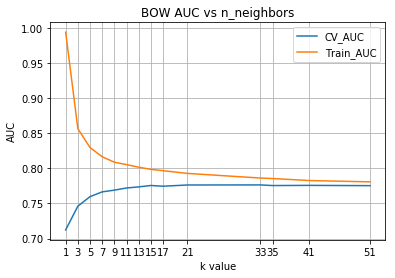

In [60]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs n_neighbors',n_neighbors)
plt.show()

**Observation**

We can see that when k was small i.e 1 model was overfitting; training AUC was 100% but CV AUC was lower around 74%. As we increased the k value model started converging to optimal value of k=41 with train auc 78% and cv auc 77%. We can see that the train and test difference is very less so model is well fitting on current feature. If we want to increased accuracy further we need to add other important features or can do the feature engineering. Its performance is better than BOW.

In [61]:
#Fitting usig best k
best_k=41
knn = KNeighborsClassifier(n_neighbors=best_k,n_jobs=-1)
knn.fit(train_svd, train_traget)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=41, p=2,
           weights='uniform')

In [62]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = knn.predict_proba(train_svd)
y_true_test = test_target
y_probas_test = knn.predict_proba(test_svd)

In [63]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

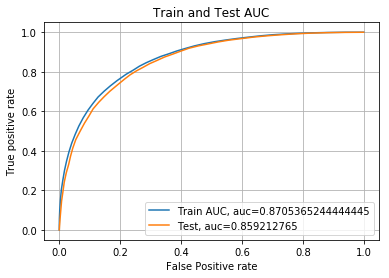

In [64]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

**Observation**

We can see that the train and test auc is almost same, so model is well fitting on current feature. If we want to increase the accuracy further we need to add some new features.

In [65]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, knn.predict(test_svd))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

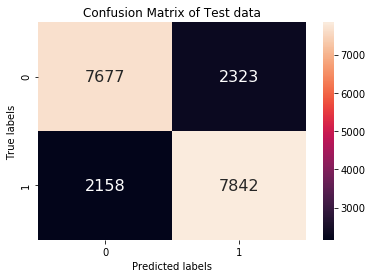

In [66]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

**Observation**

Here we have more no of elements at diagonal than off diagonal i.e more value of TP and TN compare to FP and FN, so model is working file with the current features. If we want to increase TP and TN further we need to do feature engineering.

# 6. Applying KNN KDTree on TFIDF, SET 4

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
n_neighbors=[1,3,5,7,9,11,13,15,17,21,33,35,41]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(n_neighbors):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=-1)

    # fitting the model on crossvalidation train
    knn.fit(train_svd, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = knn.predict(cv_svd)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, knn.predict(train_svd))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()

  8%|▊         | 1/13 [00:02<00:28,  2.42s/it]

 Alpha value:  1  AUC:  0.7123499999999999  Acc:  71.235  auc_train  0.99395


 15%|█▌        | 2/13 [00:10<00:45,  4.10s/it]

 Alpha value:  3  AUC:  0.7461499999999999  Acc:  74.615  auc_train  0.8565833333333334
 Alpha value:  5  AUC:  0.75975  Acc:  75.97500000000001  auc_train  0.8296833333333333


 23%|██▎       | 3/13 [00:19<00:57,  5.71s/it]

 Alpha value:  7  AUC:  0.7665500000000001  Acc:  76.655  auc_train  0.8165666666666668


 31%|███       | 4/13 [00:30<01:04,  7.13s/it]

 Alpha value:  9  AUC:  0.7689999999999999  Acc:  76.9  auc_train  0.8088


 46%|████▌     | 6/13 [00:53<01:05,  9.39s/it]

 Alpha value:  11  AUC:  0.7721  Acc:  77.21000000000001  auc_train  0.8053666666666667
 Alpha value:  13  AUC:  0.77365  Acc:  77.365  auc_train  0.8017333333333333


 54%|█████▍    | 7/13 [01:05<01:01, 10.27s/it]

 Alpha value:  15  AUC:  0.77565  Acc:  77.565  auc_train  0.7986166666666665


 62%|██████▏   | 8/13 [01:18<00:55, 11.02s/it]

 Alpha value:  17  AUC:  0.7746000000000001  Acc:  77.46  auc_train  0.79675


 77%|███████▋  | 10/13 [01:45<00:37, 12.41s/it]

 Alpha value:  21  AUC:  0.7763500000000001  Acc:  77.635  auc_train  0.79285


 85%|████████▍ | 11/13 [02:01<00:26, 13.47s/it]

 Alpha value:  33  AUC:  0.7764500000000001  Acc:  77.645  auc_train  0.7862500000000001
 Alpha value:  35  AUC:  0.77555  Acc:  77.55499999999999  auc_train  0.7855666666666667


100%|██████████| 13/13 [02:34<00:00, 15.08s/it]

 Alpha value:  41  AUC:  0.7758  Acc:  77.58  auc_train  0.7827


In [68]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values(),label='CV_AUC')
    plt.plot(list(train_map.keys()), train_map.values(),label='Train_AUC')
#     plt.semilogx(alpha, train_map.values(), label='Train_AUC')
#     plt.semilogx(alpha, test_map.values(), label='CV_AUC')
    plt.xlabel('k value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.xticks(n_neighbors)
    plt.grid()
    return plt

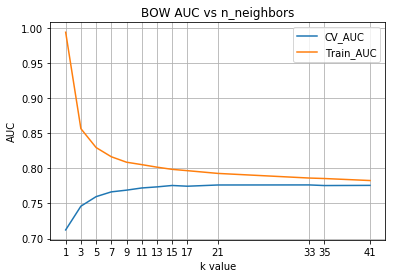

In [69]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs n_neighbors',n_neighbors)
plt.show()

**Observation**

We can see that when k was small i.e 1 model was overfitting; training AUC was 100% but CV AUC was lower around 61%. As we increased the k value model started converging to optimal value of k=41 with train auc 70% and cv auc 68%. We can see that the train and test difference is very less so model is well fitting on current feature. If we want to increased accuracy further we need to add other important features or can do the feature engineering.


In [70]:
#Fitting usig best k
best_k=41
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree',n_jobs=-1)
knn.fit(train_svd, train_traget)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=41, p=2,
           weights='uniform')

In [71]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = knn.predict_proba(train_svd)
y_true_test = test_target
y_probas_test = knn.predict_proba(test_svd)

In [72]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

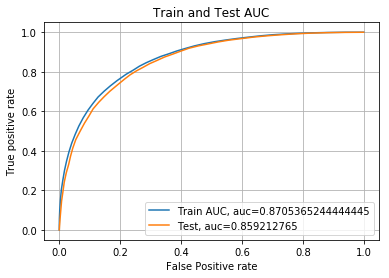

In [73]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

**Observation**

We can see that the train and test auc is almost same, so model is well fitting on current feature. If we want to increase the accuracy further we need to add some new features.

In [74]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, knn.predict(test_svd))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

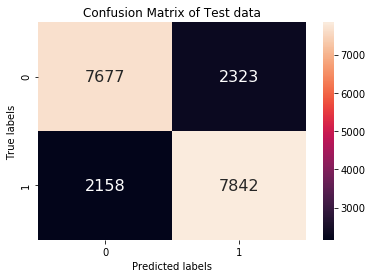

In [75]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

**Observation**


Here we have more no of elements at diagonal than off diagonal i.e more value of TP and TN compare to FP and FN, so model is working file with the current features. If we want to increase TP and TN further we need to do feature engineering.

# 7. Applying KNN brute force on AVG W2V, SET 5

**Training Word2Vec**

In [42]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in clean_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [78]:
print(clean_data['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [43]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=8)
#w2v_model.train(list_of_sent, total_examples=len(list_of_sent), epochs=10) if you want to customize training 

In [44]:
w2v_model.wv.most_similar('tasti')

[('tastey', 0.8086031079292297),
 ('yummi', 0.7950287461280823),
 ('delici', 0.7574282884597778),
 ('satisfi', 0.7514985799789429),
 ('satifi', 0.7042676210403442),
 ('hearti', 0.6933664083480835),
 ('good', 0.6893070936203003),
 ('nice', 0.6755648851394653),
 ('nutriti', 0.6725857257843018),
 ('versatil', 0.6566787958145142)]

In [47]:
# average Word2Vec
# compute average word2vec for each review.
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [08:28<00:00, 715.89it/s]


364171
50


In [48]:
avg_w2v_df=pd.DataFrame(sent_vectors)
avg_w2v_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.758505,-0.172168,-0.385203,-0.241811,-0.394415,-0.073644,-0.224280,0.286488,-0.087994,-0.419489,...,-0.214555,-0.435713,-0.957424,0.008468,-0.998245,-0.097955,0.065205,-0.238957,-0.527055,0.183418
1,-0.237719,0.540525,0.122643,0.263602,-0.203899,0.056436,0.157089,0.541197,0.029976,-0.144245,...,-0.182711,-0.642174,-0.606652,0.437557,-1.099607,0.252466,0.830093,0.050911,0.079497,0.014675


In [49]:
gc.collect()
avg_w2v_df[['Score','Time']]=final[['Score','Time']]
avg_w2v_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
0,-0.758505,-0.172168,-0.385203,-0.241811,-0.394415,-0.073644,-0.22428,0.286488,-0.087994,-0.419489,...,-0.957424,0.008468,-0.998245,-0.097955,0.065205,-0.238957,-0.527055,0.183418,1.0,1.303862e+09


In [50]:
# Checking the positive and negative labels
avg_w2v_df['Score'].value_counts()

1.0    211030
0.0     39688
Name: Score, dtype: int64

In [51]:
final.shape

(364171, 11)

In [53]:
avg_w2v_df.shape

(364171, 52)

In [88]:
avg_w2v_df.to_csv("avg_w2v_df.csv",index=False)

**Splitting Word2Vec into train, CV and Test**

In [55]:
#Randomly selecting 40k records
filter_data_positive=avg_w2v_df[avg_w2v_df.Score==1].sample(39000,random_state=17)
filter_data_positive.sort_values(by='Time',inplace=True,ascending=True)

In [56]:
#selecting all -ve records records
filter_data_negative=avg_w2v_df[avg_w2v_df.Score==0].sample(39000,random_state=17)
filter_data_negative.sort_values(by='Time',inplace=True,ascending=True)

In [57]:
filter_data_negative.shape

(39000, 52)

In [58]:
# Splitting Train,CV and Test for positive data
row=filter_data_positive.shape[0]
split=int(row*0.6)
train_data_positive=filter_data_positive[:split]
cv_data_positive=filter_data_positive[split:int(row*0.8)]
test_data_positive=filter_data_positive[int(row*0.8):row]
print("Total_positive_data",filter_data_positive.shape)
print("train",train_data_positive.shape,"CV",cv_data_positive.shape,"test",test_data_positive.shape)

Total_positive_data (39000, 52)
train (23400, 52) CV (7800, 52) test (7800, 52)


In [59]:
# Splitting Train,CV and Test for -ve data
row=filter_data_negative.shape[0]
split=int(row*0.6)
train_data_negative=filter_data_negative[:split]
cv_data_negative=filter_data_negative[split:int(row*0.8)]
test_data_negative=filter_data_negative[int(row*0.8):row]
print("Total_negative_data",filter_data_negative.shape)
print("train",train_data_negative.shape,"CV",cv_data_negative.shape,"test",test_data_negative.shape)

Total_negative_data (39000, 52)
train (23400, 52) CV (7800, 52) test (7800, 52)


In [60]:
train_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...


In [61]:
# Combining +ve and -ve train data and sorting based on time
train_data=np.vstack((train_data_positive, train_data_negative))
train_data=pd.DataFrame(train_data)
train_data.columns=avg_w2v_df.columns
train_data.sort_values(by='Time',inplace=True,ascending=True)
print(train_data.shape)
# Checking the positive and negative labels
train_data['Score'].value_counts()

(46800, 52)


1.0    23400
0.0    23400
Name: Score, dtype: int64

In [62]:
# Combining +ve and -ve CV data and sorting based on time
cv_data=np.vstack((cv_data_positive,cv_data_negative))
cv_data=pd.DataFrame(cv_data)
cv_data.columns=avg_w2v_df.columns
cv_data.sort_values(by='Time',inplace=True,ascending=True)
print(cv_data.shape)
# Checking the positive and negative labels
cv_data['Score'].value_counts()

(15600, 52)


0.0    7800
1.0    7800
Name: Score, dtype: int64

In [63]:
# Combining +ve and -ve test data and sorting based on time
test_data=np.vstack((test_data_positive, test_data_negative))
test_data=pd.DataFrame(test_data)
test_data.columns=avg_w2v_df.columns
test_data.sort_values(by='Time',inplace=True,ascending=True)
print(test_data.shape)
# Checking the positive and negative labels
test_data['Score'].value_counts()

(15600, 52)


0.0    7800
1.0    7800
Name: Score, dtype: int64

In [64]:
train_traget=train_data['Score'].astype('int')
cv_target=cv_data['Score'].astype('int')
test_target=test_data['Score'].astype('int')

In [65]:
train_data.iloc[:,:-2].head(1)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
23400,-0.072261,-0.631519,1.198363,0.29545,0.123251,-1.53865,0.494211,0.498906,-0.04214,-0.516918,...,0.026671,-0.46617,0.558099,-0.098661,-0.087573,1.054245,1.093834,0.375699,0.012794,0.076482


**SVD on word2vec**

In [66]:
from sklearn.decomposition import TruncatedSVD
svd_obj = TruncatedSVD(n_components=10, algorithm='arpack')
svd_obj.fit(train_data.iloc[:,:-2])
train_svd = pd.DataFrame(svd_obj.transform(train_data.iloc[:,:-2]))
cv_svd = pd.DataFrame(svd_obj.transform(cv_data.iloc[:,:-2]))
test_svd = pd.DataFrame(svd_obj.transform(test_data.iloc[:,:-2]))
#print(" training_counts ",train_svd.shape,"cv_counts ",cv_svd.shape,"test_counts",test_svd.shape)
n_comp=10
train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
cv_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]

In [67]:
train_svd.head(2)

,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10
0,2.796926,0.233419,2.689743,-0.899443,-0.453953,-0.628954,0.001854,-0.032816,0.449846,-0.002890
1,3.874119,0.350329,2.414642,0.539971,0.004018,-1.302928,0.269054,1.433065,1.424121,-0.526432


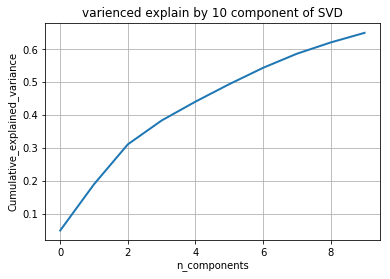

In [69]:
# SVD Varience explained
cum_var_explained = np.cumsum(svd_obj.explained_variance_ratio_)

# Plot the SVD spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.title("varienced explain by 10 component of SVD")
plt.ylabel('Cumulative_explained_variance')
plt.show()

**Observation**

We can see that with 10 compenents of SVD we are getting 65% variance on avg Word2Vec data

In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
n_neighbors=[1,3,5,7,9,11,13,15,17,21,33,35,41,51]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(n_neighbors):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)

    # fitting the model on crossvalidation train
    knn.fit(train_svd, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = knn.predict(cv_svd)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, knn.predict(train_svd))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    



  0%|          | 0/14 [00:00<?, ?it/s]

 Alpha value:  1  AUC:  0.4983333333333333  Acc:  49.833333333333336  auc_train  0.9997863247863248




  7%|▋         | 1/14 [00:02<00:35,  2.76s/it]

 14%|█▍        | 2/14 [00:10<00:49,  4.12s/it]

 Alpha value:  3  AUC:  0.5031410256410257  Acc:  50.31410256410257  auc_train  0.7501068376068376
 Alpha value:  5  AUC:  0.5041025641025642  Acc:  50.410256410256416  auc_train  0.6897008547008546




 21%|██▏       | 3/14 [00:18<01:00,  5.52s/it]

 29%|██▊       | 4/14 [00:28<01:06,  6.68s/it]

 Alpha value:  7  AUC:  0.5017307692307692  Acc:  50.17307692307692  auc_train  0.6591452991452992
 Alpha value:  9  AUC:  0.5019871794871794  Acc:  50.198717948717956  auc_train  0.6394871794871795




 36%|███▌      | 5/14 [00:38<01:09,  7.67s/it]

 43%|████▎     | 6/14 [00:48<01:08,  8.58s/it]

 Alpha value:  11  AUC:  0.5033974358974359  Acc:  50.33974358974359  auc_train  0.6232051282051282
 Alpha value:  13  AUC:  0.5016025641025641  Acc:  50.16025641025641  auc_train  0.6125




 50%|█████     | 7/14 [01:00<01:05,  9.40s/it]

 Alpha value:  15  AUC:  0.5027564102564103  Acc:  50.27564102564103  auc_train  0.6039529914529915




 57%|█████▋    | 8/14 [01:11<01:00, 10.09s/it]



 Alpha value:  17  AUC:  0.5042307692307693  Acc:  50.42307692307693  auc_train  0.5985683760683761


 64%|██████▍   | 9/14 [01:24<00:53, 10.73s/it]

 Alpha value:  21  AUC:  0.5076282051282051  Acc:  50.76282051282052  auc_train  0.5877136752136752




 71%|███████▏  | 10/14 [01:36<00:45, 11.36s/it]

 79%|███████▊  | 11/14 [01:51<00:37, 12.35s/it]

 Alpha value:  33  AUC:  0.5066025641025641  Acc:  50.66025641025641  auc_train  0.5693589743589744




 86%|████████▌ | 12/14 [02:06<00:26, 13.04s/it]

 Alpha value:  35  AUC:  0.505897435897436  Acc:  50.589743589743584  auc_train  0.5676282051282051




 93%|█████████▎| 13/14 [02:21<00:13, 13.74s/it]

 Alpha value:  41  AUC:  0.5060897435897436  Acc:  50.60897435897436  auc_train  0.5623931623931624
 Alpha value:  51  AUC:  0.5033974358974359  Acc:  50.33974358974359  auc_train  0.5540384615384616




100%|██████████| 14/14 [02:38<00:00, 14.58s/it]



In [136]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values(),label='CV_AUC')
    plt.plot(list(train_map.keys()), train_map.values(),label='Train_AUC')
#     plt.semilogx(alpha, train_map.values(), label='Train_AUC')
#     plt.semilogx(alpha, test_map.values(), label='CV_AUC')
    plt.xlabel('k value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.xticks(n_neighbors)
    plt.grid()
    return plt

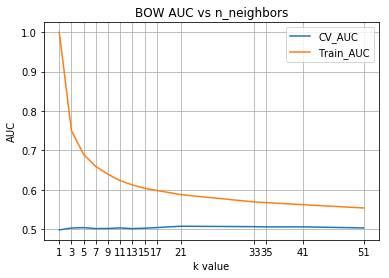

In [137]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs n_neighbors',n_neighbors)
plt.show()

**Observation**

We can see that when k was small i.e 1 model was overfitting; training AUC was 100% but CV AUC was lower around 49%. As we increased the k value model started converging to optimal value of k=41 with train auc 55% and cv auc 53%. We can see that the train and test difference is very less so model is well fitting on current feature. If we want to increased accuracy on unseen data further we need to add other important features or can do the feature engineering. In can of KNN features from word2vec is not being useful as it predicting similar to random model, so better to use BOW or TFIDF.

In [138]:
#Fitting usig best k
best_k=51
knn = KNeighborsClassifier(n_neighbors=best_k,n_jobs=-1)
knn.fit(train_svd, train_traget)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [139]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = knn.predict_proba(train_svd)
y_true_test = test_target
y_probas_test = knn.predict_proba(test_svd)

In [140]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

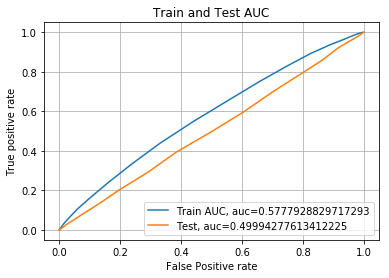

In [141]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

**Observation**

We can see that the train and test auc is having some difference, so model is not well fitting on current feature. If we want to increase the accuracy further we need to add some new features or need to do feature engineering. 

In [142]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, knn.predict(test_svd))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

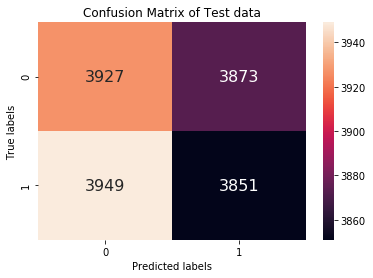

In [143]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

**Observation**

Here we have almost similar no of elements at diagonal than off diagonal i.e similar value of TP and TN compare to FP and FN, so model is not working fine with the current features. If we want to increase TP and TN further we need to do feature engineering.

# 8. Applying KNN kd-tree on AVG W2V, SET 6

In [144]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
n_neighbors=[1,3,5,7,9,11,13,15,17,21,33,35,41]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(n_neighbors):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=-1)

    # fitting the model on crossvalidation train
    knn.fit(train_svd, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = knn.predict(cv_svd)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, knn.predict(train_svd))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    



  0%|          | 0/13 [00:00<?, ?it/s]

 Alpha value:  1  AUC:  0.4983333333333333  Acc:  49.833333333333336  auc_train  0.9997863247863248




  8%|▊         | 1/13 [00:03<00:41,  3.48s/it]

 15%|█▌        | 2/13 [00:12<00:55,  5.07s/it]

 Alpha value:  3  AUC:  0.5031410256410257  Acc:  50.31410256410257  auc_train  0.7501068376068376




 23%|██▎       | 3/13 [00:22<01:06,  6.66s/it]

 Alpha value:  5  AUC:  0.5041025641025642  Acc:  50.410256410256416  auc_train  0.6897008547008546




 31%|███       | 4/13 [00:34<01:13,  8.21s/it]

 Alpha value:  7  AUC:  0.5017307692307692  Acc:  50.17307692307692  auc_train  0.6591452991452992




 38%|███▊      | 5/13 [00:46<01:15,  9.46s/it]

 Alpha value:  9  AUC:  0.5019871794871794  Acc:  50.198717948717956  auc_train  0.6394871794871795
 Alpha value:  11  AUC:  0.5033974358974359  Acc:  50.33974358974359  auc_train  0.6232051282051282




 46%|████▌     | 6/13 [01:00<01:14, 10.59s/it]

 54%|█████▍    | 7/13 [01:13<01:09, 11.52s/it]

 Alpha value:  13  AUC:  0.5016025641025641  Acc:  50.16025641025641  auc_train  0.6125
 Alpha value:  15  AUC:  0.5027564102564103  Acc:  50.27564102564103  auc_train  0.6039529914529915




 62%|██████▏   | 8/13 [01:28<01:01, 12.36s/it]

 Alpha value:  17  AUC:  0.5042307692307693  Acc:  50.42307692307693  auc_train  0.5985683760683761




 69%|██████▉   | 9/13 [01:42<00:52, 13.13s/it]

 77%|███████▋  | 10/13 [01:58<00:41, 13.86s/it]

 Alpha value:  21  AUC:  0.5076282051282051  Acc:  50.76282051282052  auc_train  0.5877136752136752


 Alpha value:  33  AUC:  0.5066025641025641  Acc:  50.66025641025641  auc_train  0.5693589743589744


 85%|████████▍ | 11/13 [02:16<00:30, 15.11s/it]

 Alpha value:  35  AUC:  0.505897435897436  Acc:  50.589743589743584  auc_train  0.5676282051282051




 92%|█████████▏| 12/13 [02:34<00:16, 16.03s/it]

100%|██████████| 13/13 [02:53<00:00, 16.93s/it]



 Alpha value:  41  AUC:  0.5060897435897436  Acc:  50.60897435897436  auc_train  0.5623931623931624


In [145]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values(),label='CV_AUC')
    plt.plot(list(train_map.keys()), train_map.values(),label='Train_AUC')
#     plt.semilogx(alpha, train_map.values(), label='Train_AUC')
#     plt.semilogx(alpha, test_map.values(), label='CV_AUC')
    plt.xlabel('k value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.xticks(n_neighbors)
    plt.grid()
    return plt

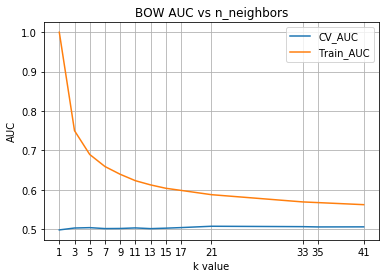

In [146]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs n_neighbors',n_neighbors)
plt.show()

**Observation**

We can see that when k was small i.e 1 model was overfitting; training AUC was 100% but CV AUC was lower around 49%. As we increased the k value model started converging to optimal value of k=41 with train auc 55% and cv auc 53%. We can see that the train and test difference is very less so model is well fitting on current feature. If we want to increased accuracy on unseen data further we need to add other important features or can do the feature engineering. In can of KNN features from word2vec is not being useful as it predicting similar to random model, so better to use BOW or TFIDF.

In [147]:
#Fitting usig best k
best_k=41
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree',n_jobs=-1)
knn.fit(train_svd, train_traget)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=41, p=2,
           weights='uniform')

In [148]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = knn.predict_proba(train_svd)
y_true_test = test_target
y_probas_test = knn.predict_proba(test_svd)

In [149]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

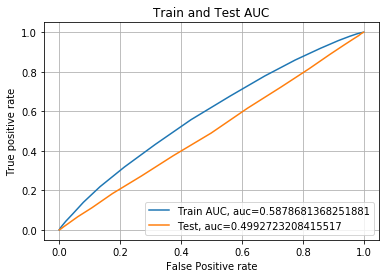

In [150]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

**Observation**

We can see that the train and test auc is having some difference, so model is not well fitting on current feature. If we want to increase the accuracy further we need to add some new features or need to do feature engineering.

In [151]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, knn.predict(test_svd))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

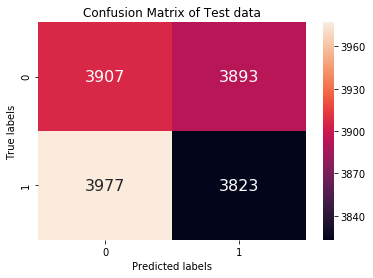

In [152]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

**Observation**

Here we have almost similar no of elements at diagonal than off diagonal i.e similar value of TP and TN compare to FP and FN, so model is not working fine with the current features. If we want to increase TP and TN further we need to do feature engineering.

# Word2vec TFIDF 

In [70]:
#Word2vec TFIDF
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(clean_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [71]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [09:18<00:00, 651.49it/s]


In [72]:
tfidf_w2v_df=pd.DataFrame(tfidf_sent_vectors)

In [86]:
gc.collect()
tfidf_w2v_df.shape

(364171, 52)

In [87]:
tfidf_w2v_df.to_csv("tfidf_w2v_df.csv",index=False)

In [74]:
tfidf_w2v_df[['Score','Time']]=final[['Score','Time']]

In [75]:
# Checking the positive and negative labels
tfidf_w2v_df['Score'].value_counts()

1.0    211030
0.0     39688
Name: Score, dtype: int64

**Splitting TFIDF into train, cv and test**

In [76]:
#Randomly selecting 50k records
filter_data_positive=tfidf_w2v_df[tfidf_w2v_df.Score==1].sample(39000,random_state=17)
filter_data_positive.sort_values(by='Time',inplace=True,ascending=True)

#selecting all -ve records records
filter_data_negative=tfidf_w2v_df[tfidf_w2v_df.Score==0].sample(39000,random_state=17)
filter_data_negative.sort_values(by='Time',inplace=True,ascending=True)

In [77]:
# Splitting Train,CV and Test for positive data
row=filter_data_positive.shape[0]
split=int(row*0.6)
train_data_positive=filter_data_positive[:split]
cv_data_positive=filter_data_positive[split:int(row*0.8)]
test_data_positive=filter_data_positive[int(row*0.8):row]
print("Total_positive_data",filter_data_positive.shape)
print("train",train_data_positive.shape,"CV",cv_data_positive.shape,"test",test_data_positive.shape)

Total_positive_data (39000, 52)
train (23400, 52) CV (7800, 52) test (7800, 52)


In [78]:
# Splitting Train,CV and Test for -ve data
row=filter_data_negative.shape[0]
split=int(row*0.6)
train_data_negative=filter_data_negative[:split]
cv_data_negative=filter_data_negative[split:int(row*0.8)]
test_data_negative=filter_data_negative[int(row*0.8):row]
print("Total_negative_data",filter_data_negative.shape)
print("train",train_data_negative.shape,"CV",cv_data_negative.shape,"test",test_data_negative.shape)

Total_negative_data (39000, 52)
train (23400, 52) CV (7800, 52) test (7800, 52)


In [79]:
# Combining +ve and -ve train data and sorting based on time
train_data=np.vstack((train_data_positive, train_data_negative))
train_data=pd.DataFrame(train_data)
train_data.columns=tfidf_w2v_df.columns
train_data.sort_values(by='Time',inplace=True,ascending=True)
print(train_data.shape)
# Checking the positive and negative labels
train_data['Score'].value_counts()

(46800, 52)


1.0    23400
0.0    23400
Name: Score, dtype: int64

In [80]:
# Combining +ve and -ve CV data and sorting based on time
cv_data=np.vstack((cv_data_positive,cv_data_negative))
cv_data=pd.DataFrame(cv_data)
cv_data.columns=tfidf_w2v_df.columns
cv_data.sort_values(by='Time',inplace=True,ascending=True)
print(cv_data.shape)
# Checking the positive and negative labels
cv_data['Score'].value_counts()

(15600, 52)


0.0    7800
1.0    7800
Name: Score, dtype: int64

In [81]:
# Combining +ve and -ve test data and sorting based on time
test_data=np.vstack((test_data_positive, test_data_negative))
test_data=pd.DataFrame(test_data)
test_data.columns=tfidf_w2v_df.columns
test_data.sort_values(by='Time',inplace=True,ascending=True)
print(test_data.shape)
# Checking the positive and negative labels
test_data['Score'].value_counts()

(15600, 52)


0.0    7800
1.0    7800
Name: Score, dtype: int64

In [82]:
train_traget=train_data['Score'].astype('int')
cv_target=cv_data['Score'].astype('int')
test_target=test_data['Score'].astype('int')

**SVD on TFIDF Word2Vec**

In [83]:
from sklearn.decomposition import TruncatedSVD
svd_obj = TruncatedSVD(n_components=10, algorithm='arpack')
svd_obj.fit(training_counts.asfptype())

TruncatedSVD(algorithm='arpack', n_components=10, n_iter=5, random_state=None,
       tol=0.0)

In [84]:
from sklearn.decomposition import TruncatedSVD
svd_obj = TruncatedSVD(n_components=10, algorithm='arpack')
svd_obj.fit(train_data.iloc[:,:-2])
train_svd = pd.DataFrame(svd_obj.transform(train_data.iloc[:,:-2]))
cv_svd = pd.DataFrame(svd_obj.transform(cv_data.iloc[:,:-2]))
test_svd = pd.DataFrame(svd_obj.transform(test_data.iloc[:,:-2]))
#print(" training_counts ",train_svd.shape,"cv_counts ",cv_svd.shape,"test_counts",test_svd.shape)
n_comp=10
train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
cv_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]

In [172]:
train_svd.head(2)

,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10
0,2.381292,2.541408,1.671134,0.260126,-0.456035,-0.600527,-0.723923,1.174698,1.173724,-0.108876
1,3.309644,1.431940,1.824377,1.070692,-1.384535,-0.663509,-0.091144,-0.787711,1.486785,0.400078


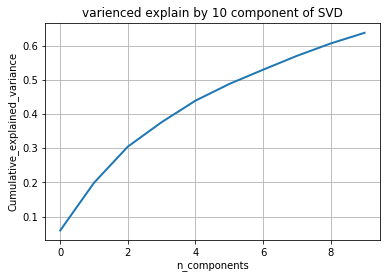

In [85]:
# SVD Varience explained
cum_var_explained = np.cumsum(svd_obj.explained_variance_ratio_)

# Plot the SVD spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.title("varienced explain by 10 component of SVD")
plt.ylabel('Cumulative_explained_variance')
plt.show()

**Observation**

We can see that with 10 compenents of SVD we are getting 65% variance on TFIDF Word2Vec data

# 9. Applying KNN Brute force on TFIDF W2V, SET 7

In [174]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
n_neighbors=[1,3,5,7,9,11,13,15,17,21,33,35,41,51]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(n_neighbors):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)

    # fitting the model on crossvalidation train
    knn.fit(train_svd, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = knn.predict(cv_svd)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, knn.predict(train_svd))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    



  0%|          | 0/14 [00:00<?, ?it/s]

 Alpha value:  1  AUC:  0.5027564102564103  Acc:  50.27564102564103  auc_train  0.9997863247863248




  7%|▋         | 1/14 [00:03<00:49,  3.83s/it]

 Alpha value:  3  AUC:  0.5056410256410256  Acc:  50.56410256410256  auc_train  0.7546367521367522




 14%|█▍        | 2/14 [00:10<00:55,  4.61s/it]

 Alpha value:  5  AUC:  0.5053205128205128  Acc:  50.532051282051285  auc_train  0.691474358974359




 21%|██▏       | 3/14 [00:17<01:00,  5.48s/it]



 Alpha value:  7  AUC:  0.5051923076923077  Acc:  50.519230769230774  auc_train  0.6590598290598292


 29%|██▊       | 4/14 [00:26<01:03,  6.34s/it]

 Alpha value:  9  AUC:  0.5072435897435897  Acc:  50.72435897435897  auc_train  0.6371794871794871




 36%|███▌      | 5/14 [00:35<01:04,  7.14s/it]



 Alpha value:  11  AUC:  0.5048717948717949  Acc:  50.48717948717949  auc_train  0.6241880341880341


 43%|████▎     | 6/14 [00:44<01:02,  7.87s/it]



 Alpha value:  13  AUC:  0.5057692307692309  Acc:  50.57692307692307  auc_train  0.6153418803418803


 50%|█████     | 7/14 [00:54<00:59,  8.50s/it]

 57%|█████▋    | 8/14 [01:05<00:54,  9.06s/it]

 Alpha value:  15  AUC:  0.5058333333333332  Acc:  50.583333333333336  auc_train  0.6076282051282051


 Alpha value:  17  AUC:  0.5028205128205128  Acc:  50.28205128205128  auc_train  0.5991880341880341


 64%|██████▍   | 9/14 [01:15<00:48,  9.60s/it]

 71%|███████▏  | 10/14 [01:27<00:40, 10.13s/it]

 Alpha value:  21  AUC:  0.506025641025641  Acc:  50.60256410256411  auc_train  0.5896794871794873




 79%|███████▊  | 11/14 [01:40<00:33, 11.01s/it]

 Alpha value:  33  AUC:  0.5016666666666666  Acc:  50.16666666666667  auc_train  0.5711752136752136


 Alpha value:  35  AUC:  0.5001282051282051  Acc:  50.01282051282051  auc_train  0.5703632478632479


 86%|████████▌ | 12/14 [01:53<00:23, 11.70s/it]

 Alpha value:  41  AUC:  0.4973076923076923  Acc:  49.730769230769226  auc_train  0.5648076923076922




 93%|█████████▎| 13/14 [02:07<00:12, 12.34s/it]

 Alpha value:  51  AUC:  0.49788461538461537  Acc:  49.78846153846154  auc_train  0.5577991452991453




100%|██████████| 14/14 [02:22<00:00, 13.06s/it]



In [175]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values(),label='CV_AUC')
    plt.plot(list(train_map.keys()), train_map.values(),label='Train_AUC')
#     plt.semilogx(alpha, train_map.values(), label='Train_AUC')
#     plt.semilogx(alpha, test_map.values(), label='CV_AUC')
    plt.xlabel('k value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.xticks(n_neighbors)
    plt.grid()
    return plt

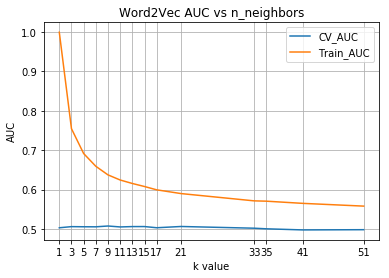

In [177]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'Word2Vec AUC vs n_neighbors',n_neighbors)
plt.show()

**Observation**

We can see that when k was small i.e 1 model was overfitting; training AUC was 100% but CV AUC was lower around 49%. As we increased the k value model started converging to optimal value of k=41 with train auc 55% and cv auc 53%. We can see that the train and test difference is very less so model is well fitting on current feature. If we want to increased accuracy on unseen data further we need to add other important features or can do the feature engineering. In can of KNN features from word2vec is not being useful as it predicting similar to random model, so better to use BOW or TFIDF.

In [178]:
#Fitting usig best k
best_k=51
knn = KNeighborsClassifier(n_neighbors=best_k,n_jobs=-1)
knn.fit(train_svd, train_traget)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [179]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = knn.predict_proba(train_svd)
y_true_test = test_target
y_probas_test = knn.predict_proba(test_svd)

In [180]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

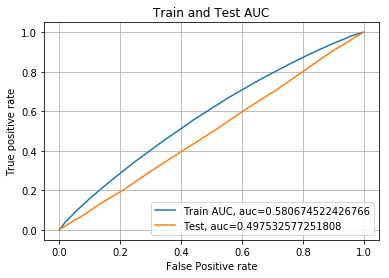

In [181]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

**Observation**

We can see that the train and test auc is having some difference, so model is not well fitting on current feature. If we want to increase the accuracy further we need to add some new features or need to do feature engineering.

In [182]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, knn.predict(test_svd))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

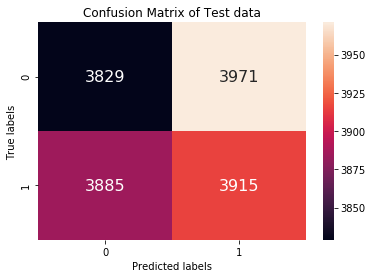

In [183]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

**Observation**

Here we have almost similar no of elements at diagonal than off diagonal i.e similar value of TP and TN compare to FP and FN, so model is not working fine with the current features. If we want to increase TP and TN further we need to do feature engineering.

# 10. Applying KNN kd-tree on TFIDF W2V, SET 8

In [184]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
n_neighbors=[1,3,5,7,9,11,13,15,17,21,33,35,41]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(n_neighbors):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=-1)

    # fitting the model on crossvalidation train
    knn.fit(train_svd, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = knn.predict(cv_svd)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, knn.predict(train_svd))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    



  0%|          | 0/13 [00:00<?, ?it/s]

 Alpha value:  1  AUC:  0.5027564102564103  Acc:  50.27564102564103  auc_train  0.9997863247863248




  8%|▊         | 1/13 [00:02<00:32,  2.75s/it]

 15%|█▌        | 2/13 [00:11<00:48,  4.45s/it]

 Alpha value:  3  AUC:  0.5056410256410256  Acc:  50.56410256410256  auc_train  0.7546367521367522




 23%|██▎       | 3/13 [00:21<01:01,  6.15s/it]

 Alpha value:  5  AUC:  0.5053205128205128  Acc:  50.532051282051285  auc_train  0.691474358974359




 31%|███       | 4/13 [00:32<01:08,  7.65s/it]

 Alpha value:  7  AUC:  0.5051923076923077  Acc:  50.519230769230774  auc_train  0.6590598290598292
 Alpha value:  9  AUC:  0.5072435897435897  Acc:  50.72435897435897  auc_train  0.6371794871794871




 38%|███▊      | 5/13 [00:44<01:11,  8.94s/it]



 Alpha value:  11  AUC:  0.5048717948717949  Acc:  50.48717948717949  auc_train  0.6241880341880341


 46%|████▌     | 6/13 [00:57<01:10, 10.08s/it]

 Alpha value:  13  AUC:  0.5057692307692309  Acc:  50.57692307692307  auc_train  0.6153418803418803




 54%|█████▍    | 7/13 [01:10<01:06, 11.06s/it]

 Alpha value:  15  AUC:  0.5058333333333332  Acc:  50.583333333333336  auc_train  0.6076282051282051




 62%|██████▏   | 8/13 [01:24<00:59, 11.93s/it]



 Alpha value:  17  AUC:  0.5028205128205128  Acc:  50.28205128205128  auc_train  0.5991880341880341


 69%|██████▉   | 9/13 [01:38<00:50, 12.69s/it]

 Alpha value:  21  AUC:  0.506025641025641  Acc:  50.60256410256411  auc_train  0.5896794871794873




 77%|███████▋  | 10/13 [01:54<00:40, 13.50s/it]

 85%|████████▍ | 11/13 [02:11<00:29, 14.68s/it]

 Alpha value:  33  AUC:  0.5016666666666666  Acc:  50.16666666666667  auc_train  0.5711752136752136




 92%|█████████▏| 12/13 [02:29<00:15, 15.59s/it]

 Alpha value:  35  AUC:  0.5001282051282051  Acc:  50.01282051282051  auc_train  0.5703632478632479
 Alpha value:  41  AUC:  0.4973076923076923  Acc:  49.730769230769226  auc_train  0.5648076923076922




100%|██████████| 13/13 [02:47<00:00, 16.47s/it]



In [185]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values(),label='CV_AUC')
    plt.plot(list(train_map.keys()), train_map.values(),label='Train_AUC')
#     plt.semilogx(alpha, train_map.values(), label='Train_AUC')
#     plt.semilogx(alpha, test_map.values(), label='CV_AUC')
    plt.xlabel('k value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.xticks(n_neighbors)
    plt.grid()
    return plt

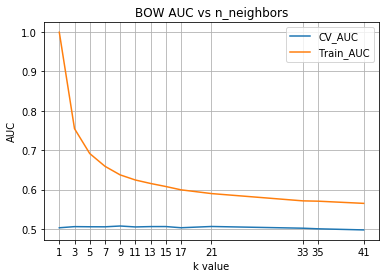

In [186]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs n_neighbors',n_neighbors)
plt.show()

**Observation**

We can see that when k was small i.e 1 model was overfitting; training AUC was 100% but CV AUC was lower around 49%. As we increased the k value model started converging to optimal value of k=41 with train auc 55% and cv auc 53%. We can see that the train and test difference is very less so model is well fitting on current feature. If we want to increased accuracy on unseen data further we need to add other important features or can do the feature engineering. In can of KNN features from word2vec is not being useful as it predicting similar to random model, so better to use BOW or TFIDF.

In [187]:
#Fitting usig best k
best_k=41
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree',n_jobs=-1)
knn.fit(train_svd, train_traget)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=41, p=2,
           weights='uniform')

In [188]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = knn.predict_proba(train_svd)
y_true_test = test_target
y_probas_test = knn.predict_proba(test_svd)

In [189]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

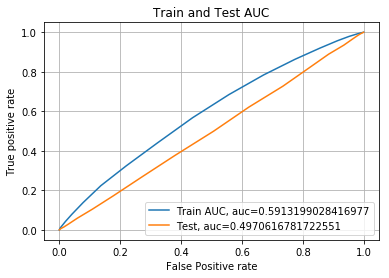

In [190]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

**Observation**


We can see that the train and test auc is having some difference, so model is not well fitting on current feature. If we want to increase the accuracy further we need to add some new features or need to do feature engineering.

In [191]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, knn.predict(test_svd))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

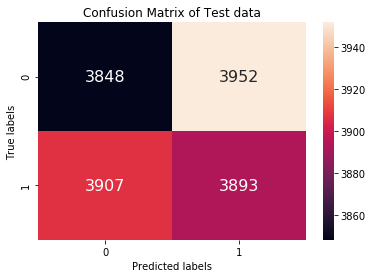

In [192]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

**Observation**

Here we have almost similar no of elements at diagonal than off diagonal i.e similar value of TP and TN compare to FP and FN, so model is not working fine with the current features. If we want to increase TP and TN further we need to do feature engineering.

In [1]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best k", "AUC"]

x.add_row(["BOW", "Brute", 51, 0.75])
x.add_row(["BOW_KDtree", "KDtree", 51, 0.77])
x.add_row(["TFIDF", "Brute NB", 51, 0.84])
x.add_row(["TFIDF_KDTree", "KDtree", 51, 0.83])
x.add_row(["AvgWord2Vec", "Brute NB", 51, 0.50])
x.add_row(["AvgWord2Vec_KDtree", "KDtree", 51, 0.50])
x.add_row(["TFIDFWord2Vec", "Brute NB", 41, 0.50])
x.add_row(["TFIDFWord2Vec_KDTree", "KDtree", 41, 0.50])
print(x)

+----------------------+----------+--------+------+
|      Vectorizer      |  Model   | Best k | AUC  |
+----------------------+----------+--------+------+
|         BOW          |  Brute   |   51   | 0.75 |
|      BOW_KDtree      |  KDtree  |   51   | 0.77 |
|        TFIDF         | Brute NB |   51   | 0.84 |
|     TFIDF_KDTree     |  KDtree  |   51   | 0.83 |
|     AvgWord2Vec      | Brute NB |   51   | 0.5  |
|  AvgWord2Vec_KDtree  |  KDtree  |   51   | 0.5  |
|    TFIDFWord2Vec     | Brute NB |   41   | 0.5  |
| TFIDFWord2Vec_KDTree |  KDtree  |   41   | 0.5  |
+----------------------+----------+--------+------+


**Observation**

We can see that the TFIDF features of text performing better than BOW and Word2Vec with AUC of 84%, 76% and 50% respectively. Here Word2Vec is not performing well on KNN with either of brute force of KDTree algorithm. For BOW and TFIDF the performace of brute and KDTree is almost similar.